In [2]:
import pyedflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

/var/folders/cy/s7_pzg4x2xxcg7cty448hrxc0000gn/T/ipykernel_34080/3990049993.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:

# Function to read EDF file and convert to DataFrame
def edf_to_dataframe(edf_file_path):
    # Reading the EDF file
    f = pyedflib.EdfReader(edf_file_path)
    
    # Extracting signal labels
    signal_labels = f.getSignalLabels()
    
    # Initializing a dictionary to store signals
    signals_dict = {}
    
    # Extract each signal and store in the dictionary
    for i, label in enumerate(signal_labels):
        signals_dict[label] = f.readSignal(i)
    
    # Close the EDF file
    print(f.readSignal(0))
    f.close()
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame(signals_dict)
    
    return df

# Example usage
edf_file_path = 'export.edf'  # Replace with your EDF file path
df = edf_to_dataframe(edf_file_path)

# Display the first few rows of the DataFrame

[-4.34234316e+01 -4.44081002e+01 -4.76575063e+01 ... -2.94950555e-01
  1.22103396e+01  4.50000000e-04]


In [4]:
# The numpy format of the EEG data
ts = df.values
ts = np.reshape(ts, (ts.shape[1],ts.shape[0]))

In [5]:
# Turning the data into 5 second bins.
size = 3000
trials = np.zeros((int(ts.shape[1]/size), ts.shape[0], size))

for i in range(trials.shape[0]):
    s = i*size
    trials[i,:,:] = ts[:,s:s+size]

In [6]:
# band pass filter for extracting different behaviors of the data
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut, highcut, fs=600, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y


In [7]:
# putting all of them together
bandpass_data = np.zeros((trials.shape[0], 3, trials.shape[2]))
for i in range (trials.shape[0]):
    bandpass_data[i, 0, :] = np.abs(bandpass_filter(trials[i,0,:], 0.5 , 4)) #Delta
    bandpass_data[i, 1, :] = np.abs(bandpass_filter(trials[i,0,:], 6 , 10)) #Theta
    bandpass_data[i, 2, :] = np.abs(bandpass_data[i,1,:]/bandpass_data[i,0,:])# Theta to Delta Ratio

In [8]:
# putting all the features together
xdata = np.zeros((trials.shape[0], 10)) # means and stds for EEG, Delta, Theta, Theta/Delta, and EMG
for i in range (xdata.shape[0]):
    # EEG
    xdata[i,0] = np.mean(np.abs(trials[i,0,:]))
    xdata[i,1] = np.std(np.abs(trials[i,0,:]))
    # Delta
    xdata[i,2] = np.mean(bandpass_data[i,0,:])
    xdata[i,3] = np.std(bandpass_data[i,0,:])
    # Theta
    xdata[i,4] = np.mean(bandpass_data[i,1,:])
    xdata[i,5] = np.std(bandpass_data[i,1,:])
    # Theta/Delta
    xdata[i,6] = np.mean(bandpass_data[i,2,:])
    xdata[i,7] = np.std(bandpass_data[i,2,:])
    # EMG
    xdata[i,8] = np.mean(np.abs(trials[i,2,:]))
    xdata[i,9] = np.std(np.abs(trials[i,2,:]))

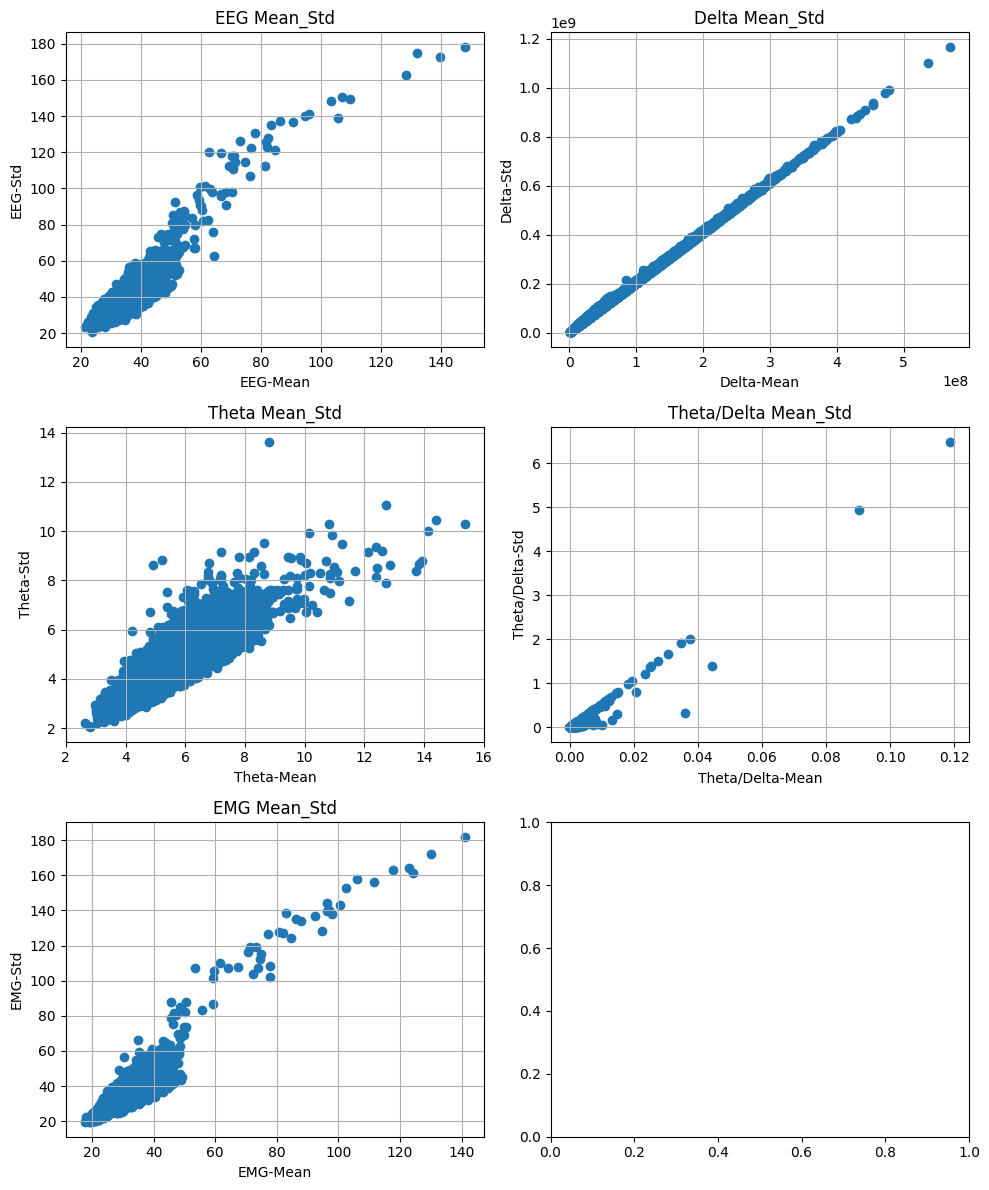

In [9]:
#  Visualizing each of the features

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# EEG Mean-Std
axes[0,0].scatter(xdata[:,0], xdata[:,1])
axes[0,0].set_title('EEG Mean_Std')
axes[0,0].set_xlabel('EEG-Mean')
axes[0,0].set_ylabel('EEG-Std')
axes[0,0].grid()

# Delta Mean-Std
axes[0,1].scatter(xdata[:,2], xdata[:,3])
axes[0,1].set_title('Delta Mean_Std')
axes[0,1].set_xlabel('Delta-Mean')
axes[0,1].set_ylabel('Delta-Std')
axes[0,1].grid()

# Theta Mean-Std
axes[1,0].scatter(xdata[:,4], xdata[:,5])
axes[1,0].set_title('Theta Mean_Std')
axes[1,0].set_xlabel('Theta-Mean')
axes[1,0].set_ylabel('Theta-Std')
axes[1,0].grid()

# Theta/Delta Mean-Std
axes[1,1].scatter(xdata[:,6], xdata[:,7])
axes[1,1].set_title('Theta/Delta Mean_Std')
axes[1,1].set_xlabel('Theta/Delta-Mean')
axes[1,1].set_ylabel('Theta/Delta-Std')
axes[1,1].grid()

# EEG Mean-Std
axes[2,0].scatter(xdata[:,8], xdata[:,9])
axes[2,0].set_title('EMG Mean_Std')
axes[2,0].set_xlabel('EMG-Mean')
axes[2,0].set_ylabel('EMG-Std')
axes[2,0].grid()




# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

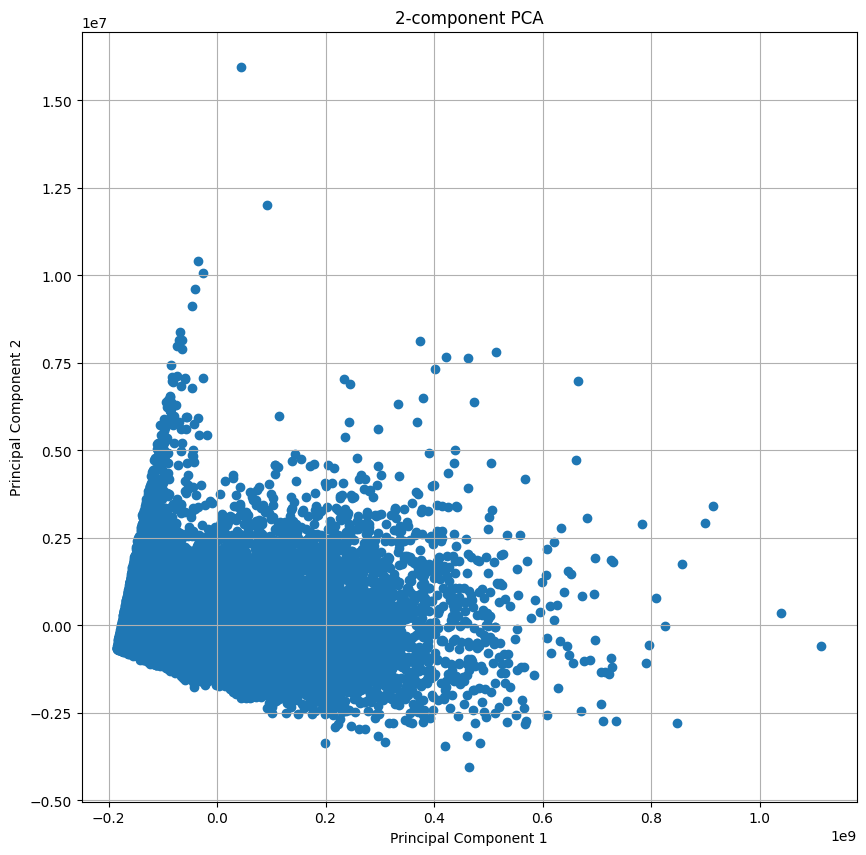

In [10]:
# The 10 feature dataset on 2 axis for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(xdata)

principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

#  Visualizing the result
plt.figure(figsize=(10, 10))
plt.scatter(principal_df['PC1'], principal_df['PC2'])
plt.title('2-component PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

In [11]:
#Kmeans for clustering the data into 3 parts
kmeans = KMeans(n_clusters=3)  # Assuming 3 clusters: awake, NREM, REM
labels = kmeans.fit_predict(xdata)

/Users/pouya/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


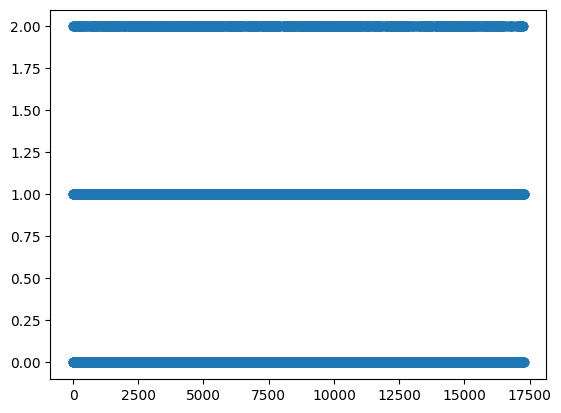

In [12]:
# conditions for entire 24hr
plt.plot(labels,'o')